# Aula 2 - Redes Convolucionais

Redes Convolucionais são um tipo de rede neural que é muito utilizada para processamento de imagens. Elas são capazes de aprender padrões espaciais em imagens, como bordas, texturas e formas. A arquitetura de uma rede convolucional é composta por camadas convolucionais, camadas de pooling e camadas densas.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

## Importando Imagens

In [46]:
path_folder = "../data/cat_dog_data"
image_folder = Path(path_folder)

In [47]:
filepaths = list(image_folder.glob(r'**/*.jpg'))
print("Total images : ", len(filepaths))

Total images :  1400


## Tratando Imagens
Vamos importar algumas imagens e fazer o tratamento necessário para que possamos utilizá-las em uma rede convolucional.

In [48]:
labels = []
images = []

# Tamanho da imagem
image_size = 64

for file in filepaths:
    # Get the image label (folder name)
    label = os.path.split(os.path.split(file)[0])[1]
    labels.append(label)
    
    # Read the image
    img = cv2.imread(str(file))
    # Importante normalizar os valores dos pixels das imagens
    img = cv2.resize(img, (image_size, image_size)).astype(np.float32) / 255.0
    images.append(img)

labels = np.array(labels)
images = np.array(images)

Verificando o shape dos arrays

In [49]:
images.shape

(1400, 64, 64, 3)

In [50]:
labels.shape

(1400,)

## Separando em Treino e Teste

In [51]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [52]:
print("Train data shape : ", X_train.shape, y_train.shape)
print("Test data shape : ", X_test.shape, y_test.shape)

Train data shape :  (1120, 64, 64, 3) (1120,)
Test data shape :  (280, 64, 64, 3) (280,)


Para passar as imagens para a rede convolucional, precisamos achatar as imagens, ou seja, sair de um array multidimensional para um array unidimensional. Para isso, vamos utilizar a função `reshape` do numpy.

In [53]:
# O parametro -1 é para a função reshape inferir o tamanho da dimensão (o equivalente a X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
#X_train_flat = X_train.reshape(X_train.shape[0], -1)
#X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [54]:
#X_train_flat.shape

Vamos converter a target para uma variável binária usando o LabelEncoder.

In [77]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [80]:
# Convertendo para tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.int64)

## Treinando o Modelo

In [212]:
configs = dict(
    epochs = 30,
    learning_rate = 1e-4,
    weight_decay = 1e-5,
    batch_size = 20
)

if torch.cuda.is_available():
    configs['device'] = torch.device('cuda')
elif torch.backends.mps.is_available():
    configs['device'] = torch.device('mps')
else:
    configs['device'] = torch.device('cpu')

print(f"Using device: {configs['device']}")

Using device: mps


In [213]:
# Criando Dataset
train_set = TensorDataset(X_train_tensor, y_train_tensor)
test_set = TensorDataset(X_test_tensor, y_test_tensor)

# Criando DataLoader
train_loader = DataLoader(train_set, batch_size=configs['batch_size'], shuffle=True)
test_loader = DataLoader(test_set, batch_size=configs['batch_size'], shuffle=True)

PAra calcular a resolução espacial do mapa de ativação (ou mapa de características) de uma camada convolucional, podemos usar a seguinte fórmula:

$$
\text{Resolução Espacial} = \frac{\text{Resolução Espacial da Entrada} - \text{Tamanho do Filtro} + 2 \times \text{Padding}}{\text{Stride}} + 1
$$

In [214]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=2, padding=1), # 64x64x3 -> 32x32x128
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=1), # 32x32x128 -> 17x17x128
    nn.BatchNorm2d(128),
    nn.Dropout(0.2),
    nn.Conv2d(in_channels=128, out_channels=92, kernel_size=3, stride=2, padding=1), # 16x16x128 -> 9x9x92
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=1), # 9x9x92 -> 5x5x92
    nn.BatchNorm2d(92),
    nn.Flatten(), # 5x5x92 -> 2300
    nn.Linear(2300, 256),
    nn.ReLU(),
    nn.Linear(256, 2),
    nn.Softmax(dim=1)
).to(mps_device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=configs['learning_rate'], weight_decay=configs['weight_decay'])

In [215]:
def train(train_loader, model):

    model.train()

    epoch_loss = []
    predict_list, target_list = [], []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(mps_device), target.to(mps_device)
        
        output = model(data)
        loss = loss_fn(output, target)

        #metrics
        epoch_loss.append(loss.item())
        _, predict = torch.max(output, 1)
        predict_list.append(predict.cpu().numpy())
        target_list.append(target.cpu().numpy())

        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    result_predict = np.asarray(predict_list).ravel()
    result_target = np.asarray(target_list).ravel()
    acc = metrics.accuracy_score(result_target, result_predict)
    
    print(f"TRAIN - Loss: {np.mean(epoch_loss)} - Acc: {acc}")

    return epoch_loss, acc

def validate(test_loader, model):

    model.eval()

    epoch_loss = []
    predict_list, target_list = [], []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(mps_device), target.to(mps_device)
            
            output = model(data)
            loss = loss_fn(output, target)

            #metrics
            epoch_loss.append(loss.item())
            _, predict = torch.max(output, 1)
            predict_list.append(predict.cpu().numpy())
            target_list.append(target.cpu().numpy())

    result_predict = np.asarray(predict_list).ravel()
    result_target = np.asarray(target_list).ravel()
    acc = metrics.accuracy_score(result_target, result_predict)
    
    print(f"VALIDATE - Loss: {np.mean(epoch_loss)} - Acc: {acc}")

    return epoch_loss, acc

def fit(train_loader, test_loader, model, epochs):
    epoch_loss_train = []
    epoch_loss_test = []
    epoch_acc_train = []
    epoch_acc_test = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} -------------------------------")
        train_loss, train_acc = train(train_loader, model)
        test_loss, test_acc = validate(test_loader, model)
        
        epoch_loss_train.append(np.mean(train_loss[0]))
        epoch_loss_test.append(np.mean(test_loss[0]))
        epoch_acc_train.append(train_acc)
        epoch_acc_test.append(test_acc)

        print("\n")

    return epoch_loss_train, epoch_loss_test, epoch_acc_train, epoch_acc_test

In [216]:
(loss_train, 
loss_test, 
acc_train, 
acc_test) = fit(train_loader, test_loader, model, configs['epochs'])

Epoch 1 -------------------------------
TRAIN - Loss: 0.655222835285323 - Acc: 0.6116071428571429
VALIDATE - Loss: 0.6427056065627507 - Acc: 0.6142857142857143


Epoch 2 -------------------------------
TRAIN - Loss: 0.5842823109456471 - Acc: 0.7258928571428571
VALIDATE - Loss: 0.5891139166695731 - Acc: 0.7321428571428571


Epoch 3 -------------------------------
TRAIN - Loss: 0.5447098985314369 - Acc: 0.775
VALIDATE - Loss: 0.5952462213379996 - Acc: 0.7035714285714286


Epoch 4 -------------------------------
TRAIN - Loss: 0.5073770146284785 - Acc: 0.8294642857142858
VALIDATE - Loss: 0.5831238201686314 - Acc: 0.7178571428571429


Epoch 5 -------------------------------
TRAIN - Loss: 0.4719093165227345 - Acc: 0.8723214285714286
VALIDATE - Loss: 0.5903096050024033 - Acc: 0.7


Epoch 6 -------------------------------
TRAIN - Loss: 0.43908437713980675 - Acc: 0.9080357142857143
VALIDATE - Loss: 0.5748925634792873 - Acc: 0.7214285714285714


Epoch 7 -------------------------------
TRAIN - Lo

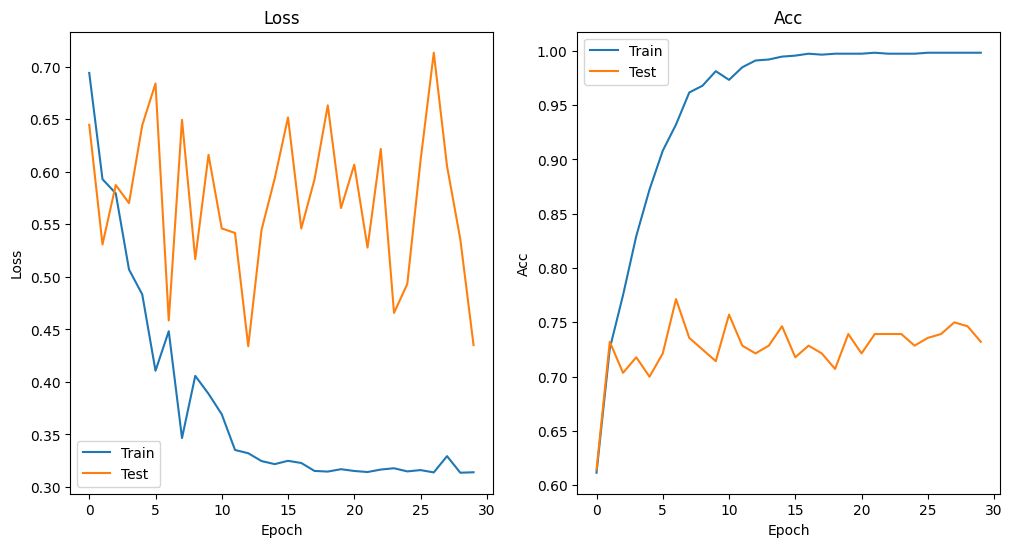

In [217]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_train, label='Train')
plt.plot(loss_test, label='Test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_train, label='Train')
plt.plot(acc_test, label='Test')
plt.title('Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()


Vamos armazenar as predições do modelo em um array

In [241]:
def predict(model, data):
    model.to(configs['device'])
    model.eval()
    with torch.no_grad():
        data = data.to(configs['device'])
        output = model(data)
        _, predict = torch.max(output, 1)
    return np.asarray(predict.cpu())

In [242]:
cnn_predict = predict(model, X_test_tensor)
cnn_predict

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0])

In [245]:
metrics.confusion_matrix(y_test_encoded, cnn_predict)


array([[109,  31],
       [ 44,  96]])

In [247]:
print(metrics.classification_report(y_test_encoded, cnn_predict, target_names=le.classes_))

              precision    recall  f1-score   support

         cat       0.71      0.78      0.74       140
         dog       0.76      0.69      0.72       140

    accuracy                           0.73       280
   macro avg       0.73      0.73      0.73       280
weighted avg       0.73      0.73      0.73       280



In [256]:
def predict_image(filepath):
    img = cv2.imread(filepath)
    img = cv2.resize(img, (64, 64)).astype(np.float32) / 255.0
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    return le.classes_[predict(model, img).item()]

In [263]:
file = "../data/cat_dog_data/teste/dog.jpg"

predict_image(file)

'dog'